# Plotting some cool results

In [ ]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

from google.colab import drive
drive.mount('/content/drive')

sys.path.append("/content/drive/MyDrive/GSOC-NMR-project/Work/Notebooks")
from auxillary_functions import *
from polynomial_featextract import poly_featextract

Mounted at /content/drive


In [ ]:
# import raw data and params.txt file
datadir_path = "/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-06-21_classify_datagen_all_funcs"

rawdata = load_data(datadir_path)
params = load_params(datadir_path)
ker_integrals = load_wlist(datadir_path) # load wlist.txt file

# Stencil type : {'0' : 'Gaussian', '1' : 'Power Law', '2' : 'RKKY'}

Finished loading rawdata into numpy array
Finsihed loading parameters file
finished loading kernel-integrals file.


In [ ]:
print(rawdata.shape)
offset = 150
shifted_data, center = get_window(rawdata,2/3,width=offset)
print("The Echo pulse occurs at timestep:",center)

# Rescaled data
rscl_data = shifted_data / np.max(shifted_data,axis=1,keepdims=True)

(10500, 943)
The Echo pulse occurs at timestep: 628


## ML regression on params

In [ ]:
y_classes = get_yclasses(params, ker_integrals)

## Using timeseries data

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [ ]:
def fit_RFregressor(X: np.ndarray, y_classes: pd.DataFrame, kfold:int):
    """Fits a RF regressor for all the parameters in y_classes using X and 
    returns the cross-validation scores for X_train and final score on (X_test, y_test)

    Args:
        X : X dataframe that is used to train the model
        y_classes : Pandas dataframe with the predictors-label as the col-name

    Returns: 
        [cv_scores, models, model_scores, y_preds]
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y_classes,
                                                    test_size=0.2, random_state=1,
                                                    stratify=params['stencil_type'] )
    
    cv_scores=[]; models=[]; model_scores=[]; y_preds = [];

    for col in y_train.columns.tolist():
        
        model = RandomForestRegressor(n_estimators=40,
                              min_samples_split=5, max_features="sqrt",
                              n_jobs=-1)
        
        print(f"Running cross-validation for {col}")
        cv_scores.append(cross_val_score(model, X_train, y_train[col], cv=kfold,
                                         verbose=1, n_jobs=-1))

        print(f"Training for {col}")
        model.fit(X_train, y_train[col])
        models.append(model)
        print(f"Model fitted for {col}. Now scoring")
        model_scores.append(model.score(X_test, y_test[col]))
        y_preds.append((y_test[col], model.predict(X_test)))
        print()

    return [cv_scores, models, model_scores, y_preds]

In [ ]:
regr = fit_RFregressor(rscl_data, y_classes, 10)

Running cross-validation for αx


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   26.1s finished


Training for αx
Model fitted for αx. Now scoring

Running cross-validation for αz


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   25.3s finished


Training for αz
Model fitted for αz. Now scoring

Running cross-validation for len_scale


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   32.6s finished


Training for len_scale
Model fitted for len_scale. Now scoring



In [ ]:
cv_scores = [f"{regr[0][i].mean():.3} "+r"$\pm$"+f" {regr[0][i].std():.3}" for i in range(len(regr[0]))]
cv_scores

['0.953 $\\pm$ 0.00759', '0.959 $\\pm$ 0.0036', '0.841 $\\pm$ 0.0761']

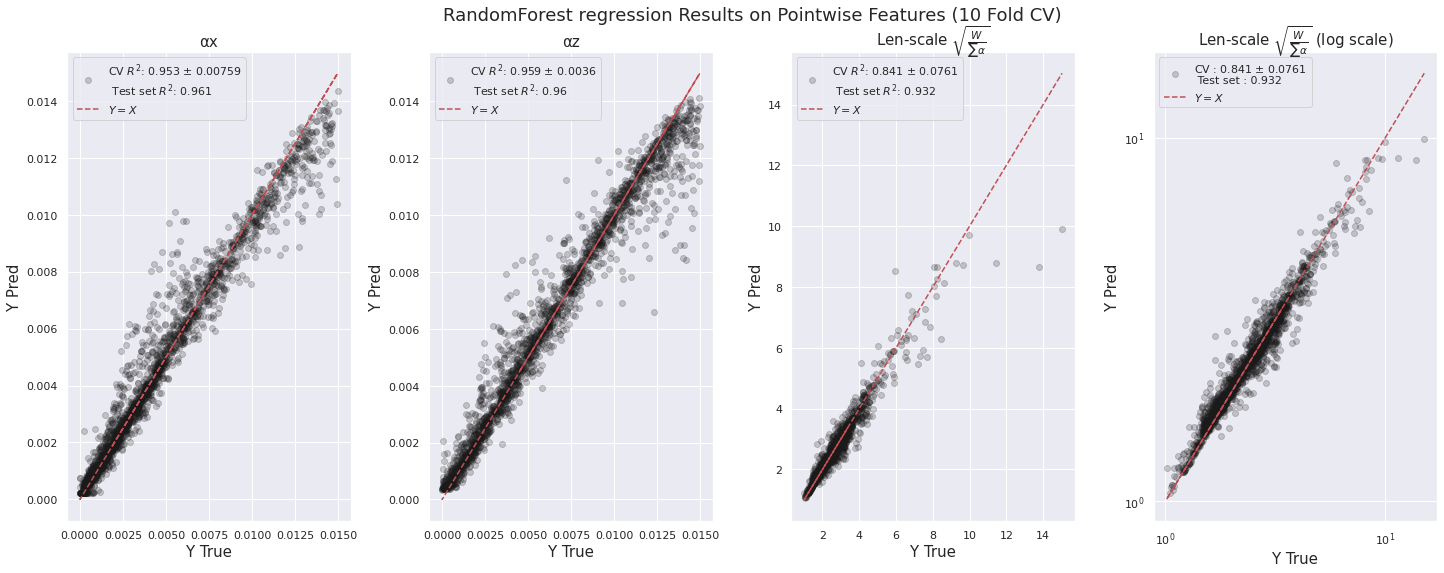

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(21,9))

for idx, ax in enumerate(axes):
    if idx <3 :  
        ax.plot(regr[3][idx][0].values, regr[3][idx][1], 'ko', alpha=0.2, label=f"CV $R^2$: {cv_scores[idx]}\n Test set $R^2$: {regr[2][idx]:.3}")
        ax.plot(regr[3][idx][0].values, regr[3][idx][0].values, 'r--', label=r"$Y=X$")
        ax.legend()
        ax.set_title(y_classes.columns.tolist()[idx], fontsize=15)
        ax.set_xlabel('Y True', fontsize=15)
        ax.set_ylabel('Y Pred', fontsize=15)
    else:
        ax.plot(regr[3][2][0].values, regr[3][2][1], 'ko', alpha=0.2, label=f"CV : {cv_scores[2]}\n Test set : {regr[2][2]:.3}")
        ax.plot(regr[3][2][0].values, regr[3][2][0].values, 'r--', label=r"$Y=X$")
        ax.legend()
        ax.set_title(r"Len-scale $\sqrt{\frac{W}{\sum \alpha}}$ (log scale)", fontsize=15)
        ax.set_xlabel('Y True', fontsize=15)
        ax.set_ylabel('Y Pred', fontsize=15)
        plt.yscale("log")
        plt.xscale("log")

axes[2].set_title(r"Len-scale $\sqrt{\frac{W}{\sum \alpha}}$", fontsize=15)

plt.suptitle("RandomForest regression Results on Pointwise Features (10 Fold CV)", fontsize=18)
plt.tight_layout(rect=[0.,0.1,0.96, 0.97])

### Feature importance plots

### First try for $\alpha _x$ 

In [ ]:
def get_fi_tseries(model):

    fi = pd.DataFrame(np.array([np.arange(1,301).astype(int),
                                model.feature_importances_ ]).T, 
                    columns=['timestamp','fi'])
    return fi


In [ ]:
fi_ax,fi_az,fi_ls = list(map(get_fi_tseries, regr[1]))

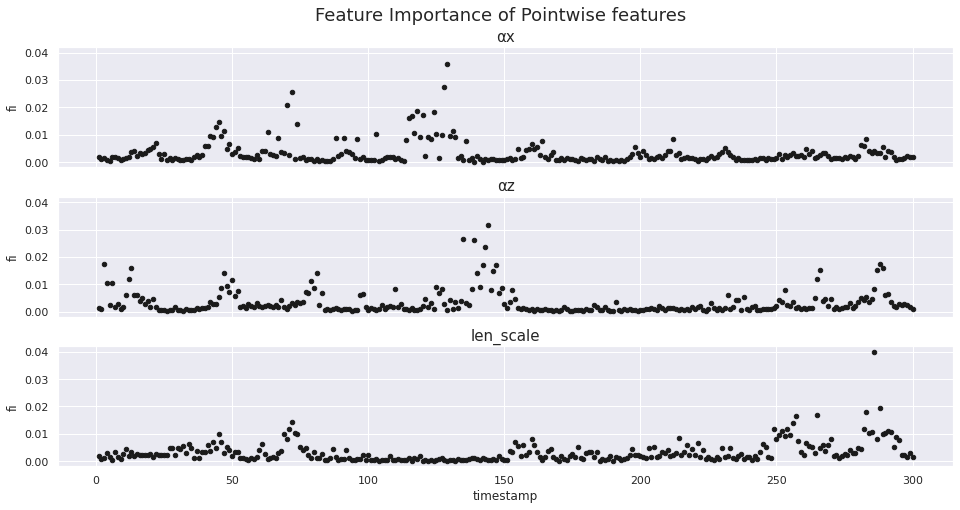

In [ ]:
fig, axes = plt.subplots(3,1,figsize=(14,8), sharex=True, sharey=True)

for idx, fi in enumerate([fi_ax,fi_az,fi_ls]):
    fi.plot.scatter(x='timestamp', y='fi', color='k', ax=axes[idx])
    axes[idx].set_title(y_classes.columns.tolist()[idx], fontsize=15)

plt.suptitle("Feature Importance of Pointwise features", fontsize=18)
plt.tight_layout(rect=[0.,0.1,0.96, 0.96])

### Try to plot decision tree

In [ ]:
!pip install dtreeviz

In [ ]:
!pip install graphviz

In [ ]:
#from dtreeviz.trees import dtreeviz
import graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [ ]:
# ax predictor
regr[1][0].estimators_[0]

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=2041798213, splitter='best')

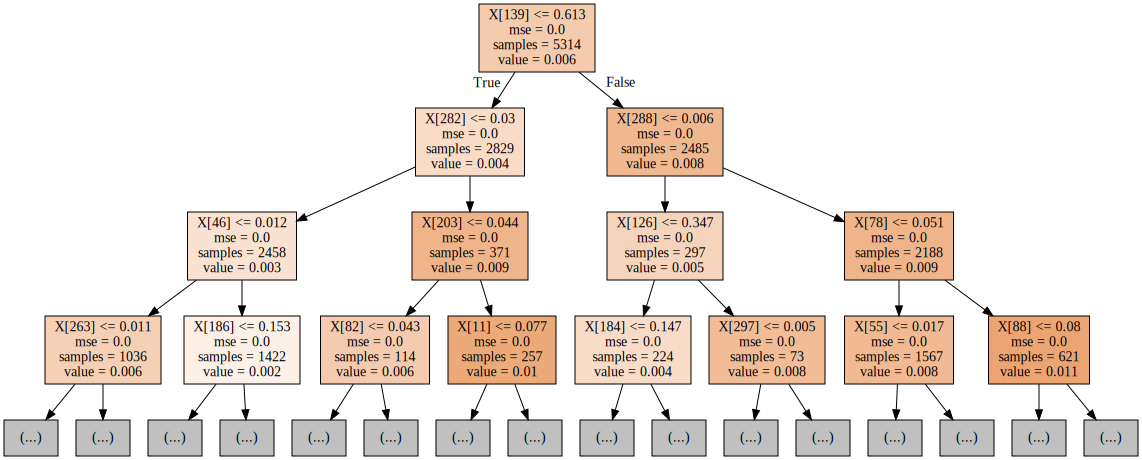

In [34]:
for i in range(40): 
    dot_data = tree.export_graphviz(regr[1][1].estimators_[0], 
                                out_file=None, 
                                max_depth=3, class_names=params['stencil_type'], 
                                filled=True)
graphviz.Source(dot_data, format="svg") 

### Try a decision tree for $\alpha _x$

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(rscl_data, y_classes['αx'],
                                                    test_size=0.2, random_state=1,
                                                    stratify=params['stencil_type'] )

In [ ]:
clf = DecisionTreeRegressor(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
clf.score(X_test, y_test)

0.5645532650124434

In [ ]:
fig = plt.figure(figsize=(30,35))
viz = dtreeviz(clf, 
               x_data=X_train,
               y_data=y_train,
               target_name=r'$\alpha _x$', 
               feature_names=[f"feature {i}" for i in range(1,301)],
               title="Decision Tree - Pointwise Features data")
viz

Output hidden; open in https://colab.research.google.com to view.